# Imports

In [1]:
#!pip install labelbox
# !pip install google.cloud
#!pip install google-cloud-secret-manager

In [2]:
#!pip install geojson
#!pip install opencv-python
#!pip install pyproj
#!pip install pygeotile
#!pip install imagesize

In [3]:
#!pip uninstall tensorflow tensorflow-hub tensorflow-estimator -y
#!pip install psutil
#!pip install tensorflow tensorflow-hub tensorflow-estimator

In [4]:
#!pip install openCV-python
#!pip install --upgrade -q git+https://github.com/keras-team/keras-cv

In [5]:
from google.cloud import storage
from google.cloud import secretmanager

import labelbox
from labelbox import Project, Dataset, Client, MediaType
from labelbox.data.annotation_types import *
import labelbox.data.annotation_types as lb_types

from labelbox.data.serialization import NDJsonConverter
from labelbox.data.metrics import (
    feature_miou_metric, 
    feature_confusion_matrix_metric
)
from labelbox.data.serialization import LBV1Converter
from datetime import datetime
import uuid

import tensorflow as tf
import requests
from io import BytesIO
import numpy as np
from tensorflow import keras
import tensorflow_estimator
import tensorflow_hub as hub 
from keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNet
from tensorflow.keras import optimizers
import keras_cv
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm
#from keras_cv import FasterRCNN

2023-09-27 21:47:59.259568: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


# Cloud Connection

In [6]:
secret_client = secretmanager.SecretManagerServiceClient()
gc_project_id = "35596334323"
secret_id_lb = "lb_api_key"
secret_id_hsp_model = "hsp-crop-v1-id"
version_id_hsp_model = "1"
version_id_lb = "2"  # "latest" can be used to get the latest version

# Construct the resource name of the secret version
name_lb = f"projects/{gc_project_id}/secrets/{secret_id_lb}/versions/{version_id_lb}"
name_model = f"projects/{gc_project_id}/secrets/{secret_id_hsp_model}/versions/{version_id_hsp_model}"


# Fetch the secret
response_lb = secret_client.access_secret_version(request={"name": name_lb})
response_model = secret_client.access_secret_version(request={"name": name_model})

# Extract the secret from the response
api_key = response_lb.payload.data.decode("UTF-8")
model_key = response_model.payload.data.decode("UTF-8")

In [7]:
# Initialize Labelbox Client
client = Client(api_key, enable_experimental=True)
project = client.get_project('cll2vfg6l0bvd0729fvgo2gsr') #project ID 

# Initialize Google Cloud Storage Client
storage_client = storage.Client()
bucket = storage_client.get_bucket("db-bucket-1")

In [8]:
# Replace 'your_project_id' and 'your_model_run_id' with actual IDs
model_run_id = "a24dad91-5416-0afa-00c5-59964b80e014"
model_run = client.get_model_run(model_run_id)

In [9]:
# export labels and model config from Labelbox model run
lb_labels_json = model_run.export_labels(download=True)
lb_labels = list(LBV1Converter.deserialize(lb_labels_json))
lb_config = model_run.get_config()
print("model training config: ", lb_config)

model training config:  {'epochs': 5, 'lr_gamma': 0.1, 'momentum': 0.9, 'batch_size': 521, 'lr_step_size': 10, 'weight_decay': 0.0005, 'learning_rate': 0.0005}


In [10]:
import psutil

def print_memory_usage():
    memory_info = psutil.virtual_memory()
    total_memory = round(memory_info.total / (1024.0 ** 3), 2)  # Total physical memory.
    used_memory = round(memory_info.used / (1024.0 ** 3), 2)  # Total physical memory used.
    available_memory = round(memory_info.available / (1024.0 ** 3), 2)  # The available memory left for use.
    
    print(f"Total Memory: {total_memory} GB")
    print(f"Used Memory: {used_memory} GB")
    print(f"Available Memory: {available_memory} GB")

# You can call this function before and after running memory-intensive operations.
print_memory_usage()


Total Memory: 31.36 GB
Used Memory: 0.81 GB
Available Memory: 30.16 GB


# Image Processing

In [90]:
def download_and_process_image(url):
    image_string = tf.io.read_file(url)
    
    image_decoded = tf.image.decode_image(image_string)
    print(image_decoded.shape[0])
    print(image_decoded.shape[1])
    
    resizing = keras_cv.layers.Resizing(640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh")
    image_resized = resizing([image_decoded])
    return image_resized

def load_and_process_data(label):
    box = []
    image_label = []
    image_url = label.data.url
    image = download_and_process_image(image_url)
    w, h = 4032, 3024
    new_h, new_w = 640,640
    if len(label.annotations) > 1:
        for annot in label.annotations:
            if annot.name == "harbor seals":
                bbox = annot.value
                x_min, y_min, x_max, y_max = bbox.start.x, bbox.start.y, bbox.end.x, bbox.end.y
            
                 # Adjust bounding boxes
                x_min = (x_min / w) * new_w
                y_min = (y_min / h) * new_h
                x_max = (x_max / w) * new_w
                y_max = (y_max / h) * new_h

                # Add label (assuming 'Seals' corresponds to label 1)
                box.append([x_min, y_min, x_max, y_max])
                image_label.append(1) # for seals
    else: 
        box.append([0,0,0,0])
        image_label.append(0) # for no seals in image

    return image, box, image_label

In [91]:
images = []
boxes = []
image_labels = []

for label in lb_labels:
    processed_image, processed_box, processed_label = load_and_process_data(label)
    images.append(processed_image)
    boxes.append(processed_box)
    image_labels.append(processed_label)

3024
4032
3024
4032
3024
4032
3024
4032
3024
4032
3024
4032
3024
4032
3024
4032
3024
4032


KeyboardInterrupt: 

In [ ]:
print(boxes[0])

In [ ]:
images = tf.convert_to_tensor(images)
boxes = tf.convert_to_tensor(boxes)
image_labels = tf.convert_to_tensor(image_labels)
image_labels_float = tf.cast(image_labels, dtype=tf.float32)

# # Now, you can create the dataset
# combined_boxes_and_labels = tf.concat([boxes, tf.expand_dims(image_labels_float, axis=-1)], axis=-1)
# # Reshape to (batch_size, 1, 5)
# # Or to (batch_size, 1, 4, 1) if that's how you want to organize your dimensions
# reshaped_boxes_and_labels = tf.reshape(combined_boxes_and_labels, [-1, 1, 5])

def normalize_img_and_bbox(image, labels_dict):
    # Extract bounding_box and classification from labels_dict
    bounding_box = labels_dict['bounding_box']
    classification = labels_dict['classification']
    # Normalize image to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    
    # Assuming image dimensions are 640x640 and bbox format is [x1, y1, x2, y2, tag]
    # Normalize bounding box to [0, 1]
    bounding_box = tf.cast(bounding_box, tf.float32) / 640.0
    
    return image, {"bounding_box": bounding_box, "classification": classification}

labels_dict = {"bounding_box": boxes, "classification": image_labels}
dataset = tf.data.Dataset.from_tensor_slices((images, {"bounding_box": boxes, "classification": image_labels}))
dataset = dataset.map(normalize_img_and_bbox)
dataset = dataset.batch(20)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
print(dataset.element_spec)

In [ ]:
total_batches = len(list(dataset))  # Replace with the actual size of your dataset
train_size = int(0.7 * total_batches)
val_size = int(0.15 * total_batches)
test_size = int(0.15 * total_batches)

remaining = total_batches - (train_size + val_size + test_size)
train_size += remaining  # Add the remaining to the train set

# Calculate the number of batches needed for each split
print(f"the number of batches for this set: {train_size}")
print(f"the number of batches for this set: {val_size}")
print(f"the number of batches for this set: {test_size}")


# # Shuffle the dataset
dataset = dataset.shuffle(buffer_size=total_batches, reshuffle_each_iteration=False)

# Create a fresh copy of the shuffled dataset for each split
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

the number of batches for this set: 19
the number of batches for this set: 4
the number of batches for this set: 4


In [ ]:
def plot_images_test(dataset, image_w, image_h):
    for x_batch, y_batch in dataset.take(1):
            bb_box_true = y_batch['bounding_box']
            class_labels_true = y_batch['classification']

            for i, image in enumerate(x_batch):
                # Unnormalize the image
                image = x_batch[i].numpy()
                image = (image * 255).astype('uint8')
                
                true_box = bb_box_true[i].numpy() * 640 # Assuming boxes are [x_min, y_min, x_max, y_max]
                true_label = int(class_labels_true[i].numpy())
                
                cv2.rectangle(image, (int(true_box[0]), int(true_box[1])), (int(true_box[2]), int(true_box[3])), (255, 0, 0), 2)
                
                cv2.putText(image, f"True: {true_label}", (int(true_box[0]), int(true_box[1]) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.show()

In [ ]:
print(train_dataset.element_spec)

In [ ]:
def remove_extra_dims(image, labels):
    # Squeeze the extra dimensions from the bounding box tensor
    labels['bounding_box'] = tf.squeeze(labels['bounding_box'], axis=1)
    
    return image, labels

# Apply the function to each element in the dataset
train_dataset = train_dataset.map(remove_extra_dims)
val_dataset = val_dataset.map(remove_extra_dims)
test_dataset = test_dataset.map(remove_extra_dims)

In [ ]:
train_dataset = train_dataset.map(lambda x, y: (tf.squeeze(x, axis=1), y))
val_dataset = val_dataset.map(lambda x, y: (tf.squeeze(x, axis=1), y))
test_dataset = test_dataset.map(lambda x, y: (tf.squeeze(x, axis=1), y))

In [ ]:
print(train_dataset.element_spec)

In [ ]:
for x_batch, y_batch in train_dataset.take(1):
    print("X shape:", x_batch.shape)
    print("Y shape:", y_batch['bounding_box'].shape, y_batch['classification'].shape)
    print(y_batch)

In [ ]:
EPOCHS = 1 #Global Environment Epoch variable for training 
def bbox_loss(y_true, y_pred, presence_label):
    
    # Calculate the mean squared error for the bounding box coordinates
    bbox_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Mask the bounding box loss based on presence_label
    # Element-wise multiplication, resulting shape will be [batch size, 1]
    masked_loss = presence_label * bbox_loss
    
    # Reduce mean across the batch
    return tf.reduce_mean(masked_loss)

def class_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

def create_complex_model():
    input_layer = tf.keras.layers.Input(shape=(640, 640, 3))
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone_coco")
    backbone = backbone(input_layer)
    
    x = layers.Flatten()(backbone)
    
    # Fully connected layers
    x = layers.Dense(1024, activation='relu')(x)
    
    # Bounding box prediction layer
    bounding_box = layers.Dense(4, activation='sigmoid', name='bounding_box')(x)
    
    # Object class prediction layer
    classification = layers.Dense(1, activation='sigmoid', name='classification')(x)
    
    model = Model(inputs=input_layer, outputs=[bounding_box, classification])
    
    return model

In [ ]:
# Create and compile the model
model = create_complex_model()

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000001)

def train_step(x_batch, y_batch):
    bbox_labels = y_batch['bounding_box']
    class_labels = y_batch['classification']
    with tf.GradientTape() as tape:
        # Forward pass
        bounding_box_preds, classification_preds = model(x_batch)
        
        # Calculate losses
        bbox_loss_value = bbox_loss(bbox_labels, bounding_box_preds, classification_preds)
        class_loss_value = class_loss(class_labels, classification_preds)
        
        # Combine losses
        alpha = 0.8
        beta = 1 - alpha
        total_loss = (alpha * bbox_loss_value) + (beta * class_loss_value)

    # Get gradients and apply them
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return bbox_loss_value, class_loss_value

In [ ]:
# Training loop
for epoch in range(EPOCHS):
    for x_batch, y_batch in train_dataset:
        bbox_loss_value, class_loss_value = train_step(x_batch, y_batch)
        print("Epoch:", (epoch + 1), "Bbox loss:", bbox_loss_value, "Class loss:", class_loss_value)
print("Finished training")

In [ ]:
#history = model.fit(train_dataset, epochs=1)

In [ ]:
# Toggle between this two lines to save and store models once I like them

### DO NOT FORGET TO RENAME THE MODEL AND UPDATE URL
model_name = 'mal_model_4'
#model.save(f'gs://db-bucket-1/models/{model_name}')

# Load model back into memory 

custom_objects = {'bbox_loss': bbox_loss, 'class_loss': class_loss}
model = load_model(f'gs://db-bucket-1/models/{model_name}', custom_objects=custom_objects)

# # Verify that the model has been loaded
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 yolov8_backbone_1 (YOLOV8B  (None, None, None, 256)      1277680   ['input_4[0][0]']             
 ackbone)                                                                                         
                                                                                                  
 flatten_1 (Flatten)         (None, 102400)               0         ['yolov8_backbone_1[0][0]']   
                                                                                                  
 dense_1 (Dense)             (None, 1024)                 1048586   ['flatten_1[0][0]']     

In [ ]:
predictions = model.predict(val_dataset)
predicted_bounding_box, predicted_classification = predictions

4/4 [==============================] - 8s 933ms/step


In [ ]:
print(predicted_bounding_box)
print(predicted_classification)

[[0.48753226 0.07510768 0.8092284  0.32504898]
 [0.48568556 0.07458146 0.8111698  0.3234279 ]
 [0.47939622 0.07275838 0.8170703  0.32539973]
 [0.4869903  0.07456284 0.8092455  0.32405177]
 [0.48093596 0.07337181 0.8140086  0.3203378 ]
 [0.47708085 0.07326407 0.8163774  0.325148  ]
 [0.47730663 0.07274    0.8152197  0.32431972]
 [0.48961806 0.07415779 0.8095977  0.32219374]
 [0.48861367 0.07388919 0.81087714 0.32313174]
 [0.4785461  0.07251623 0.8160893  0.32572082]
 [0.4752637  0.07396651 0.81592715 0.32790986]
 [0.48431227 0.07348234 0.81312066 0.32383236]
 [0.47229648 0.07381234 0.8109795  0.3029018 ]
 [0.48223063 0.07317416 0.81541276 0.32272685]
 [0.48143968 0.07285634 0.81467646 0.32540533]
 [0.47921416 0.07237361 0.81651753 0.32744148]
 [0.47631872 0.07260344 0.81563157 0.32616845]
 [0.4826343  0.07410699 0.8122475  0.31897408]
 [0.48666573 0.07323606 0.81304544 0.32164505]
 [0.47750196 0.07306988 0.81666887 0.32534742]
 [0.48778087 0.07330223 0.8124652  0.32059196]
 [0.48762465 

In [ ]:
visualize_batch = predictions[:20]

In [110]:
def plot_preds(dataset, model):
    # Extracting just one batch from the dataset
    x_batch, y_batch = next(iter(dataset.take(1)))
    predictions = model.predict(x_batch)
    bb_box_true = y_batch['bounding_box']
    class_labels_true = y_batch['classification']
    predicted_bounding_box, predicted_classification = predictions
    original_height, original_width = 3024, 4032
    #i = image choice in batch 
    i = 1
    # Extracting the first image only
    val_image = x_batch[i].numpy()
    val_image = (val_image * 255.0).astype('uint8')

    original_aspect_ratio = original_width / original_height
    
    if original_aspect_ratio > 1:
        # Original image is wider. Padding was added to height.
        resized_width = 640
        resized_height = int(640 / original_aspect_ratio)
        padding_x_left = 0
        padding_x_right = 0
        padding_y_top = 0
        padding_y_bottom = 640 - resized_height
    else:
        # Original image is taller. Padding was added to width.
        resized_height = 640
        resized_width = int(640 * original_aspect_ratio)
        padding_x_left = 0
        padding_x_right = 640 - resized_width
        padding_y_top = 0
        padding_y_bottom = 0


    # Crop out the padding
    image_without_padding = val_image[0:640-padding_y_bottom, 0:640-padding_x_right]

    scale_x = original_width / (640 - padding_x_right) # Scaling based on effective width after removing padding
    scale_y = original_height / (640 - padding_y_bottom) # Scaling based on effective height after removing padding

    # Adjust bounding boxes to account for padding and then scale to original dimensions
    true_box_unnormalized = bb_box_true[i].numpy() * 640 - [padding_x_left, padding_y_top, padding_x_left, padding_y_top]
    true_box = true_box_unnormalized * [scale_x, scale_y, scale_x, scale_y]
    pred_box_unnormalized = predicted_bounding_box[i] * 640 - [padding_x_left, padding_y_top, padding_x_left, padding_y_top]
    pred_box = pred_box_unnormalized * [scale_x, scale_y, scale_x, scale_y]
    true_label = int(class_labels_true[i].numpy())
    pred_label = int(np.round(predicted_classification[i]))
    
    image_final = cv2.resize(image_without_padding, (original_width, original_height))
    
    # Draw bounding boxes and labels on cropped image
    font_size = 5  # Adjust as necessary for your preference
    font_thickness = 10  # Adjust as necessary for your desired thickness

    cv2.rectangle(image_final, (int(true_box[0]), int(true_box[1])), (int(true_box[2]), int(true_box[3])), (0, 255, 0), 10)
    cv2.rectangle(image_final, (int(pred_box[0]), int(pred_box[1])), (int(pred_box[2]), int(pred_box[3])), (255, 0, 0), 10)

    # Adjust y-offset to account for larger font size
    y_offset = 10

    cv2.putText(image_final, f"True: {true_label}", (int(true_box[0]), int(true_box[1]) - y_offset), cv2.FONT_HERSHEY_SIMPLEX, font_size, (0, 255, 0), font_thickness)
    cv2.putText(image_final, f"Pred: {pred_label}", (int(pred_box[0]), int(pred_box[1]) - y_offset), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 0, 0), font_thickness)

    
    # Display the cropped image
    plt.imshow(image_final)
    plt.show()


1/1 [==============================] - 1s 1s/step


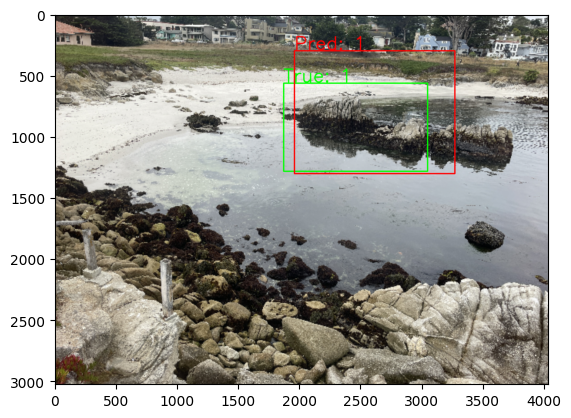

In [111]:
plot_preds(val_dataset, model)

In [11]:
export_params= {
  "attachments": True,
  "metadata_fields": True,
  "data_row_details": True,
  "project_details": True,
  "label_details": True,
  "performance_details": True
}
filters= {
  "workflow_status": "ToLabel",
}

export_task = project.export_v2(params=export_params, filters=filters)
export_task.wait_till_done()

In [12]:
unlabeled_results = export_task.result
print(unlabeled_results[0])

{'data_row': {'id': 'cllh6n74x5tli073y9w35bqdg', 'external_id': '2023-08-03T08:45:14Z', 'row_data': 'gs://db-bucket-1/gphotos/IMG_5201.JPG', 'details': {'dataset_id': 'cllh6mn5t02et073j7pnvd4vz', 'dataset_name': 'hsp_west_beach_jul26_aug11_2023', 'created_at': '2023-08-18T22:49:20.000+00:00', 'updated_at': '2023-08-18T22:49:20.000+00:00', 'last_activity_at': '2023-08-18T22:49:24.404+00:00', 'created_by': 'cshell21@stanford.edu'}}, 'media_attributes': {'height': 3024, 'width': 4032, 'mime_type': 'image/jpeg', 'exif_rotation': '1'}, 'attachments': [], 'metadata_fields': [{'schema_id': 'cko8s9r5v0001h2dk9elqdidh', 'schema_name': 'tag', 'value': 'west_beach'}, {'schema_id': 'cko8sdzv70006h2dk8jg64zvb', 'schema_name': 'captureDateTime', 'value': '2023-08-03T08:45:14.000+00:00'}], 'projects': {'cll2vfg6l0bvd0729fvgo2gsr': {'name': 'Harbor Seal Project', 'labels': [], 'project_details': {'ontology_id': 'cllh80czu07b4073rapbvclw8', 'task_name': 'Initial labeling task', 'batch_id': 'c28e49f0-3e

In [13]:
unlabeled_images = []
for result in unlabeled_results: 
    link = result['data_row']['row_data']
    unlabeled_image = download_and_process_image(link)
    unlabeled_images.append(unlabeled_image)

In [14]:
print(len(unlabeled_images))

479


In [15]:
unlabeled_images = tf.convert_to_tensor(unlabeled_images)
unlabeled_dataset = tf.data.Dataset.from_tensor_slices((unlabeled_images))
unlabeled_dataset = unlabeled_dataset.batch(20)
unlabeled_dataset = unlabeled_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
unlabeled_dataset = unlabeled_dataset.map(lambda x: (tf.squeeze(x, axis=1)))

In [17]:
print(unlabeled_dataset.element_spec)

TensorSpec(shape=(None, 640, 640, 3), dtype=tf.float32, name=None)


In [49]:
def create_pre_label_preds(dataset, model, images_metadata):
    pre_label_ontology = []
    for x_batch in unlabeled_dataset:
        pre_label_predictions = model.predict(x_batch)
        pre_labels_bounding_box, pre_labels_classification = pre_label_predictions

        for i in range(len(x_batch)):
            pre_label_box = pre_labels_bounding_box[i]
            pre_label_class = int(np.round(pre_labels_classification[i]))
            
            bbox_annotation = lb_types.ObjectAnnotation(
            name="harbor seals",  # must match your ontology feature's name
            value=lb_types.Rectangle(
                start=lb_types.Point(x=pre_label_box[0], y=pre_label_box[1]),  # x = left, y = top 
                end=lb_types.Point(x=pre_label_box[2], y=pre_label_box[3]),  # x= left + width , y = top + height
            ))
            if pre_label_class == 1: 
                radio_annotation = lb_types.ClassificationAnnotation(
                name="Are there harbor seals?",
                value=lb_types.Radio(answer=lb_types.ClassificationAnswer(
                    name="Yes")))
            else:
                radio_annotation = lb_types.ClassificationAnnotation(
                name="Are there harbor seals?",
                value=lb_types.Radio(answer=lb_types.ClassificationAnswer(
                    name="No")))

            annotations = [radio_annotation, bbox_annotation]
            image_metadata = images_metadata[i]
            image_id = image_metadata['data_row']['id']
            pre_label_ontology.append(lb_types.Label(data=lb_types.ImageData(uid = image_id),
                       annotations=annotations))
    return pre_label_ontology

In [50]:
pre_labels = create_pre_label_preds(unlabeled_dataset, model, unlabeled_results)

1/1 [==============================] - 1s 1s/step


In [51]:
print(len(pre_labels))

479


In [54]:
upload_job = labelbox.MALPredictionImport.create_from_objects(
        client = client, 
        project_id = project.uid, 
        name="mal_job"+str(uuid.uuid4()), 
        predictions=pre_labels)

print(f"Errors: {upload_job.errors}", )
print(f"Status of uploads: {upload_job.statuses}")

Errors: [{'uuid': '6b9c8ef0-81a2-4853-bc15-2a3058112fae', 'dataRow': {'id': 'cllh6n74x5tli073y9w35bqdg', 'globalKey': None}, 'status': 'FAILURE', 'errors': [{'name': 'InvalidAnnotation', 'message': 'Global classification for schema cllh83y9c08cu072u5k5ycyy7 already exists for data row cllh6n74x5tli073y9w35bqdg', 'additionalInfo': None}]}, {'uuid': '86de505e-0171-4fd7-8657-bc8f0a3ba754', 'dataRow': {'id': 'cllh6ndnsyrcl07104xt6bzmf', 'globalKey': None}, 'status': 'FAILURE', 'errors': [{'name': 'InvalidAnnotation', 'message': 'Global classification for schema cllh83y9c08cu072u5k5ycyy7 already exists for data row cllh6ndnsyrcl07104xt6bzmf', 'additionalInfo': None}]}, {'uuid': '8a4cd86d-3f4e-4ea7-a51c-fe071977b3c2', 'dataRow': {'id': 'cllh6nac74ob6076qa0j640hy', 'globalKey': None}, 'status': 'FAILURE', 'errors': [{'name': 'InvalidAnnotation', 'message': 'Global classification for schema cllh83y9c08cu072u5k5ycyy7 already exists for data row cllh6nac74ob6076qa0j640hy', 'additionalInfo': None